<a href="https://colab.research.google.com/github/dapivei/deep-learning-2020/blob/master/DL_09_AE_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoenconders: transaction anomaly

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
# GOALS:
# - Train ourselves on unsupervised deep learning.
# - Train ourselves on the use of autoencoders (AE).
# - Use an AE to estimate latent representations of some numeric data.
# - Use those latent representations to detect anomalies (abnormal data).

In [0]:
# Data set: https://www.kaggle.com/mlg-ulb/creditcardfraud
# https://www.kaggle.com/mlg-ulb/creditcardfraud/download
#
# The datasets contains transactions made by credit cards in September 2013 by european cardholders.
# This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.
# The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
#
# It contains only numerical input variables which are the result of a PCA transformation (privacy reasons).
# Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are
# 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
# The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud
# and 0 otherwise.

# Part 1: Load data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive') #autorizing permission to access content in google drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Load data
df=pd.read_csv('gdrive/My Drive/creditcard.csv')
print(df.shape)
# Remueve entries with nan values
df.dropna(inplace=True)
df.isnull().values.any()

(284807, 31)


False

In [0]:

# Show a summary
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [0]:
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


**Contando la cantidad de registros por clase**

In [0]:
# Note classes are not balanced at all
classes_count = pd.value_counts(df['Class'], sort = True)
classes_count

0    284315
1       492
Name: Class, dtype: int64

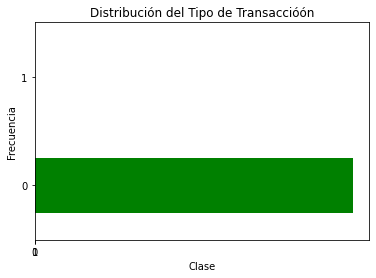

In [0]:
classes_count.plot(kind = 'barh', rot=0, color='g')
plt.title("Distribución del Tipo de Transaccióón")
plt.xticks(range(2))
plt.xlabel("Clase")
plt.ylabel("Frecuencia");

In [0]:
# summary of class 0 (normal transactions)
df[df.Class == 0].Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [0]:
# summary of class 1 (abnormal transactions)
df[df.Class == 1].Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

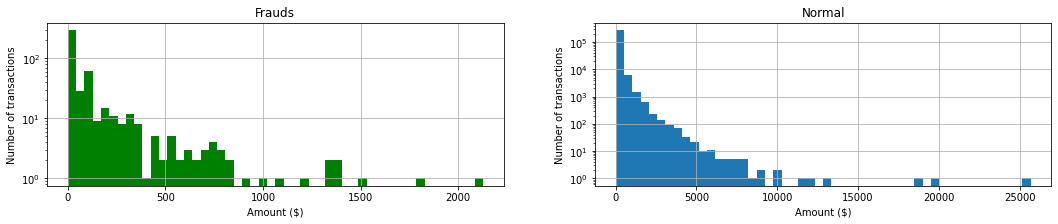

In [0]:
# Plot amount of normal and abnormal data
plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Frauds')
plt.hist(df[df.Class == 1].Amount, bins=50, color="g")
plt.xlabel('Amount ($)')
plt.ylabel('Number of transactions')
plt.yscale('log')
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Normal')
plt.hist(df[df.Class == 0].Amount, bins=50)
plt.xlabel('Amount ($)')
plt.ylabel('Number of transactions')
plt.yscale('log')
plt.grid()

plt.show()

In [0]:
# Remove time
df = df.drop(['Time'], axis=1)
print(df.shape)

(284807, 30)


In [0]:
normal = df[df.Class == 0]


In [0]:
# Extract into matrices values for normal transactions
normal = df[df.Class == 0]
normal = normal.drop(['Class'], axis=1)
normal = normal.values
print(normal.shape)

# Extract into matrices values for atypical transactions
frauds = df[df.Class == 1]
frauds = frauds.drop(['Class'], axis=1)
frauds = frauds.values
print(frauds.shape)

(284315, 29)
(492, 29)


In [0]:
# Normalize data
scaler = StandardScaler()
normal = scaler.fit_transform(normal)
frauds = scaler.transform(frauds)

# See max and min values, so we can decide on output activations
print(normal.min(axis=0))
print(normal.max(axis=0))

[-29.23383553 -44.43954405 -33.1210661   -4.05573252 -83.82683084
 -19.67269346 -26.9547933  -63.04736881  -5.77875015 -14.1265026
  -4.77604318 -16.02201219  -5.8207973  -20.51734046  -4.79911288
 -11.98281313 -22.82988537  -6.51040776  -8.88513979 -70.83041283
 -48.59368815 -15.107939   -72.09157992  -4.68293974 -19.77314077
  -5.40075462 -56.43521184 -46.81853823  -0.35301631]
[  1.26783021  11.55688816   6.42059588  12.06519875  25.6429718
  55.11588798 102.28946604  16.11172234  14.31150875  22.73057889
   9.97773414   8.28549613   7.16203997  11.72201079   9.70165636
  20.48834873  12.33161046   6.10628824   6.89039166  51.23659381
  31.55405666  14.5137363   36.24600145   7.56776948  14.44221515
   7.29394756  79.06170547 102.70355447 102.36862343]


In [0]:
# Split normal data into training and test data
x_train, x_test = train_test_split(normal, test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(227452, 29)
(56863, 29)


# Part 2: Train a model

In [0]:
from tensorflow.keras.models import Model
#import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras import regularizers
#from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


## Probando diferentes Arquitecturas

#### Propuesta del profesor

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(32, activation='relu')(in_layer)
encoder = Dense(24,  activation='relu')(encoder)

latent  = Dense(16,  activation='relu')(encoder)

decoder = Dense(24, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_43 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_44 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_45 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_46 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_47 (Dense)             (None, 29)                957

In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [0]:
# Train

history = AE.fit(x_train, x_train, epochs=32, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.4379 - accuracy: 0.4111 - val_loss: 0.2575 - val_accuracy: 0.5269
Epoch 2/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.2139 - accuracy: 0.5943 - val_loss: 0.1726 - val_accuracy: 0.6561
Epoch 3/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.1449 - accuracy: 0.6848 - val_loss: 0.1317 - val_accuracy: 0.6955
Epoch 4/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.1139 - accuracy: 0.7260 - val_loss: 0.1027 - val_accuracy: 0.7436
Epoch 5/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.1031 - accuracy: 0.7476 - val_loss: 0.0946 - val_accuracy: 0.7643
Epoch 6/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0897 - accuracy: 0.7827 - val_loss: 0.0829 - val_accuracy: 0.7922
Epoch 7/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0969 - accuracy: 0.7608 - val_loss: 0.1042 - val_accuracy:

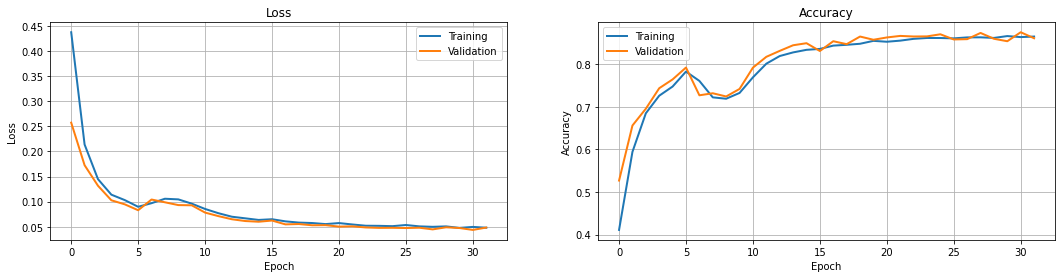

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

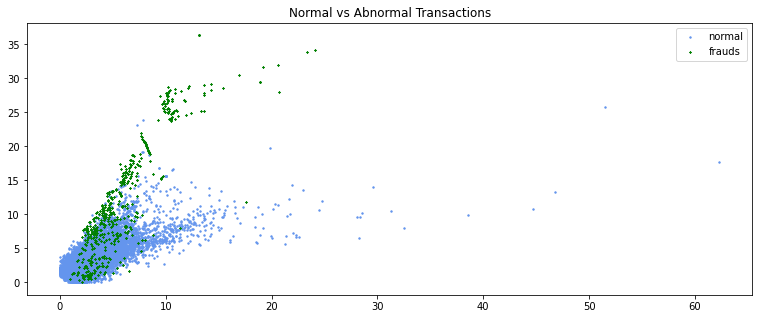

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()



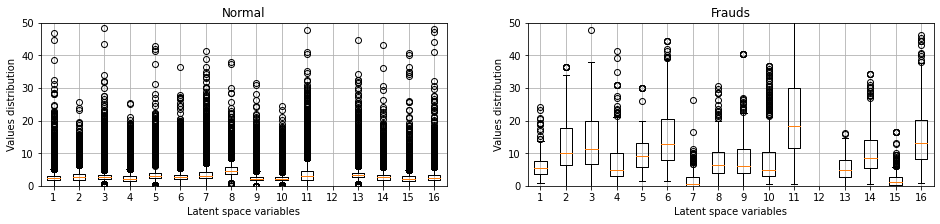

In [0]:

# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0, 50])

plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0,50])

plt.grid()
plt.show()



#### Primer Cambio: Cambios en la profundidad de la red: Red menos profunda

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(32, activation='relu')(in_layer)
#encoder = Dense(24,  activation='relu')(encoder)

latent  = Dense(16,  activation='relu')(encoder)

#decoder = Dense(24, activation='relu')(latent)
decoder = Dense(32, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_50 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_51 (Dense)             (None, 29)                957       
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train

history = AE.fit(x_train, x_train, epochs=32, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.3765 - accuracy: 0.5087 - val_loss: 0.2178 - val_accuracy: 0.6227
Epoch 2/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.1831 - accuracy: 0.6646 - val_loss: 0.1460 - val_accuracy: 0.7040
Epoch 3/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.1259 - accuracy: 0.7411 - val_loss: 0.1043 - val_accuracy: 0.7609
Epoch 4/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0987 - accuracy: 0.7766 - val_loss: 0.0866 - val_accuracy: 0.7929
Epoch 5/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0836 - accuracy: 0.8005 - val_loss: 0.0817 - val_accuracy: 0.8100
Epoch 6/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0746 - accuracy: 0.8178 - val_loss: 0.0709 - val_accuracy: 0.8140
Epoch 7/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0686 - accuracy: 0.8286 - val_loss: 0.0674 - val_accuracy:

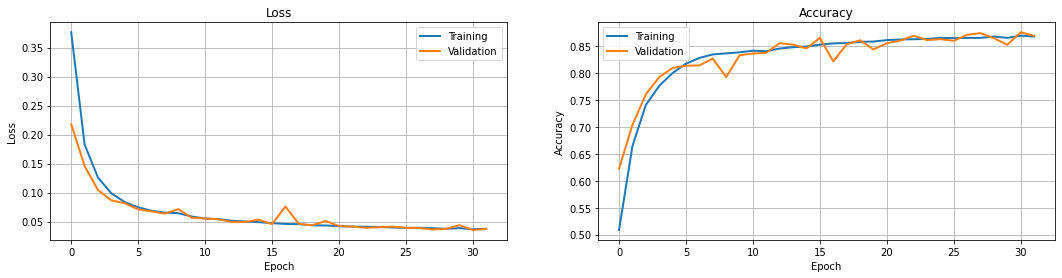

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

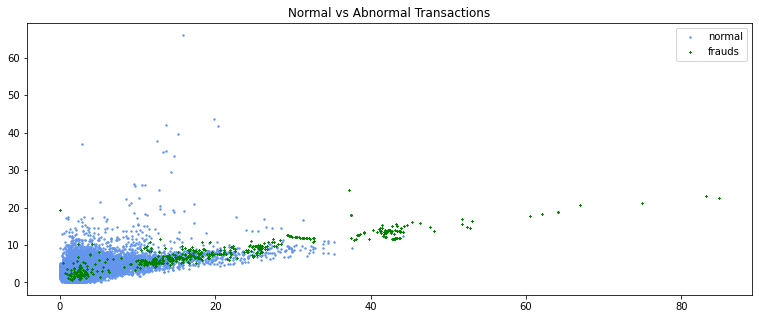

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()

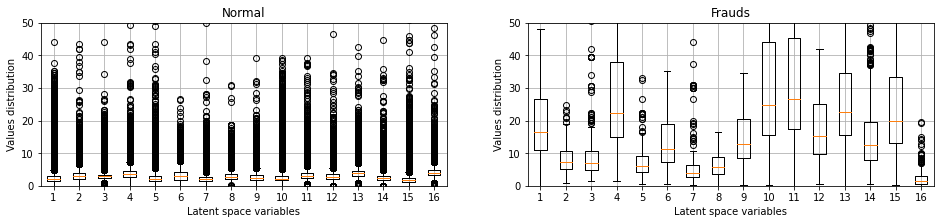

In [0]:

# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0, 50])

plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0,50])

plt.grid()
plt.show()

#### Segundo Cambio: Cambios en la profundidad de la red: Red más profunda

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(32, activation='relu')(in_layer)
encoder = Dense(24,  activation='relu')(encoder)
encoder = Dense(20,  activation='relu')(encoder)

latent  = Dense(16,  activation='relu')(encoder)

decoder = Dense(20, activation='relu')(latent)
decoder = Dense(24, activation='relu')(decoder)
decoder = Dense(32, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_53 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_54 (Dense)             (None, 20)                500       
_________________________________________________________________
dense_55 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_56 (Dense)             (None, 20)                340       
_________________________________________________________________
dense_57 (Dense)             (None, 24)                504

In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train

history = AE.fit(x_train, x_train, epochs=32, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/32
2844/2844 [==============================] - 6s 2ms/step - loss: 0.5606 - accuracy: 0.3293 - val_loss: 0.3780 - val_accuracy: 0.4589
Epoch 2/32
2844/2844 [==============================] - 6s 2ms/step - loss: 0.3199 - accuracy: 0.5221 - val_loss: 0.2557 - val_accuracy: 0.5809
Epoch 3/32
2844/2844 [==============================] - 6s 2ms/step - loss: 0.2351 - accuracy: 0.6028 - val_loss: 0.1971 - val_accuracy: 0.6392
Epoch 4/32
2844/2844 [==============================] - 6s 2ms/step - loss: 0.1859 - accuracy: 0.6457 - val_loss: 0.1583 - val_accuracy: 0.6760
Epoch 5/32
2844/2844 [==============================] - 6s 2ms/step - loss: 0.1453 - accuracy: 0.7060 - val_loss: 0.1219 - val_accuracy: 0.7367
Epoch 6/32
2844/2844 [==============================] - 6s 2ms/step - loss: 0.1216 - accuracy: 0.7424 - val_loss: 0.1331 - val_accuracy: 0.7493
Epoch 7/32
2844/2844 [==============================] - 6s 2ms/step - loss: 0.1087 - accuracy: 0.7608 - val_loss: 0.0924 - val_accuracy:

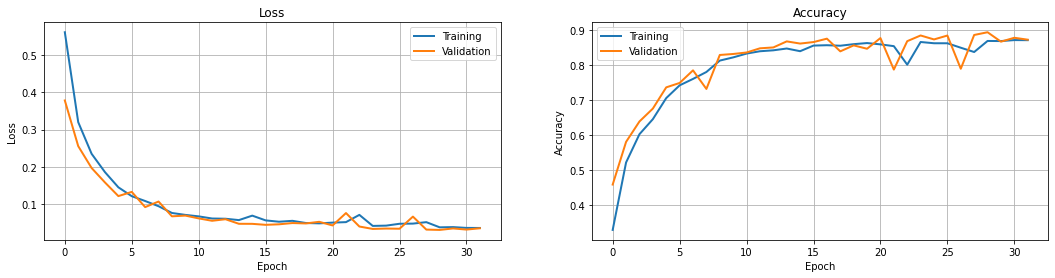

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

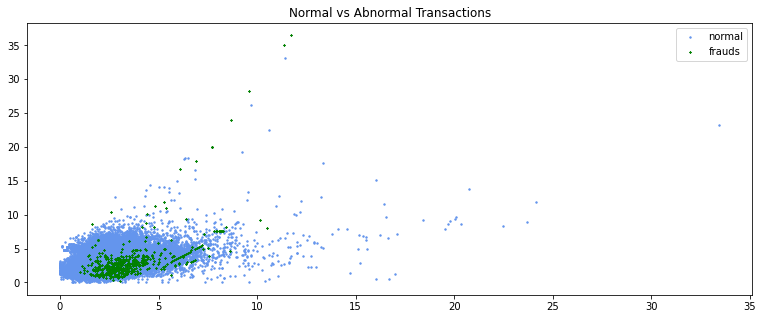

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()

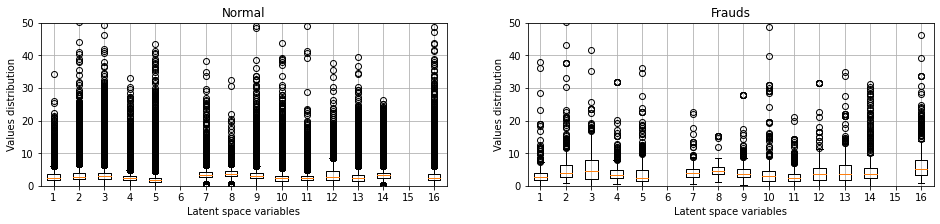

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0, 50])

plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0,50])

plt.grid()
plt.show()

#### Tercer Cambio: Quitar elementos en el espacio latente

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(32, activation='relu')(in_layer)
latent  = Dense(8,  activation='relu')(encoder)
decoder = Dense(32, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_60 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_61 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_62 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_63 (Dense)             (None, 29)                957       
Total params: 2,469
Trainable params: 2,469
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train

history = AE.fit(x_train, x_train, epochs=32, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.5769 - accuracy: 0.3289 - val_loss: 0.4371 - val_accuracy: 0.4043
Epoch 2/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.3913 - accuracy: 0.4367 - val_loss: 0.3561 - val_accuracy: 0.4625
Epoch 3/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.3362 - accuracy: 0.4777 - val_loss: 0.3196 - val_accuracy: 0.4942
Epoch 4/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.3078 - accuracy: 0.5007 - val_loss: 0.3100 - val_accuracy: 0.5142
Epoch 5/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.2860 - accuracy: 0.5235 - val_loss: 0.3290 - val_accuracy: 0.5198
Epoch 6/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.2729 - accuracy: 0.5387 - val_loss: 0.2645 - val_accuracy: 0.5468
Epoch 7/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.2596 - accuracy: 0.5502 - val_loss: 0.2567 - val_accuracy:

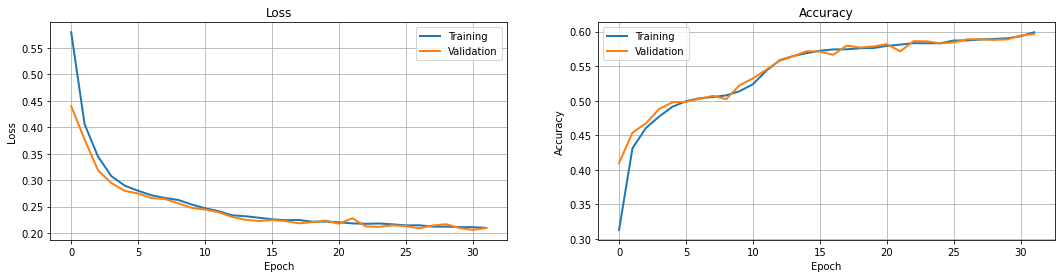

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

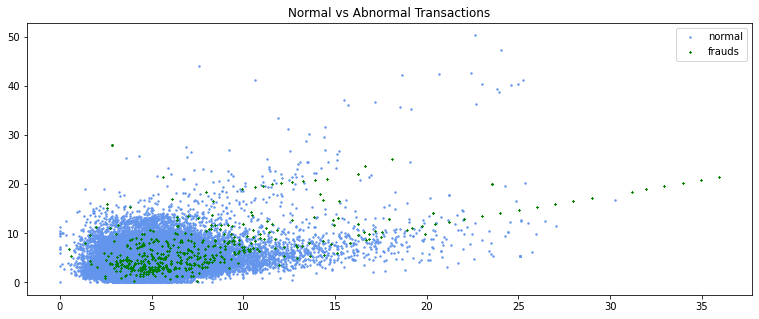

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()

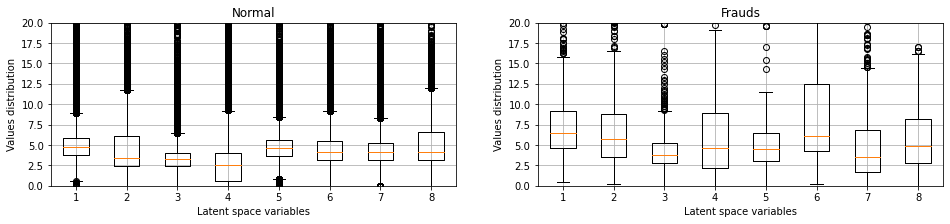

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0, 20])

plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0,20])

plt.grid()
plt.show()

#### Cuarto Cambio: Aumentar el número de elementos en el espacio latente

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(32, activation='relu')(in_layer)
latent  = Dense(29,  activation='relu')(encoder)
decoder = Dense(32, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_39 (Dense)             (None, 29)                957       
_________________________________________________________________
dense_40 (Dense)             (None, 32)                960       
_________________________________________________________________
dense_41 (Dense)             (None, 29)                957       
Total params: 3,834
Trainable params: 3,834
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train

history = AE.fit(x_train, x_train, epochs=32, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.2250 - accuracy: 0.6962 - val_loss: 0.0912 - val_accuracy: 0.7876
Epoch 2/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0243 - accuracy: 0.9386 - val_loss: 0.0081 - val_accuracy: 0.9789
Epoch 3/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0118 - accuracy: 0.9615 - val_loss: 0.0081 - val_accuracy: 0.9714
Epoch 4/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0106 - accuracy: 0.9650 - val_loss: 0.0094 - val_accuracy: 0.9714
Epoch 5/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0107 - accuracy: 0.9652 - val_loss: 0.0078 - val_accuracy: 0.9827
Epoch 6/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0104 - accuracy: 0.9665 - val_loss: 0.0076 - val_accuracy: 0.9867
Epoch 7/32
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0101 - accuracy: 0.9678 - val_loss: 0.0099 - val_accuracy:

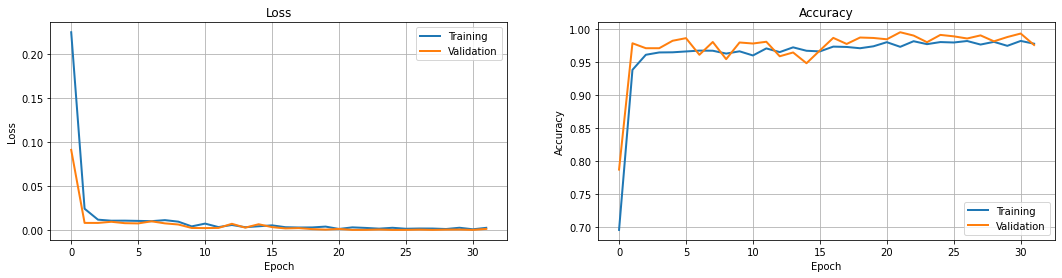

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

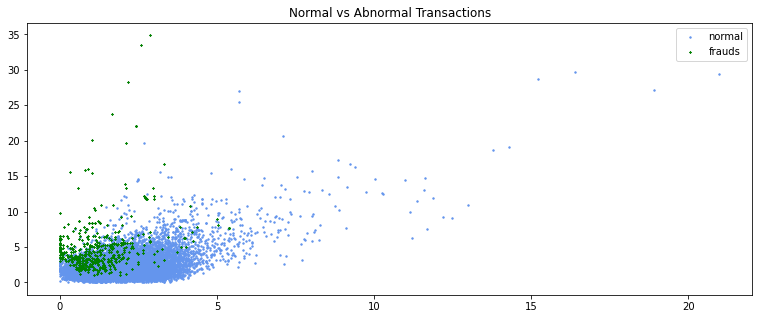

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()

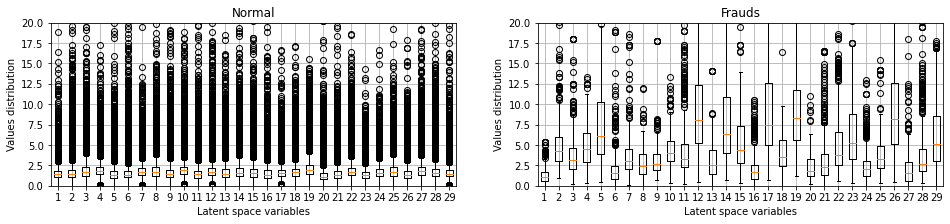

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0, 20])

plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0,20])

plt.grid()
plt.show()

#### Quinto Cambio: Aumento en el número de neuronas en los encoder/decoder: 128 neuronas

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
#encoder = Dense(64, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(in_layer)
encoder = Dense(128, activation='relu')(in_layer)
latent  = Dense(16,  activation='relu')(encoder)
decoder = Dense(128, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3840      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_9 (Dense)              (None, 29)                3741      
Total params: 11,821
Trainable params: 11,821
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = AE.fit(x_train, x_train, epochs=60, batch_size=64, validation_split=0.2)

Epoch 1/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1786 - accuracy: 0.7034 - val_loss: 0.0732 - val_accuracy: 0.8176
Epoch 2/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0597 - accuracy: 0.8336 - val_loss: 0.0505 - val_accuracy: 0.8401
Epoch 3/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0428 - accuracy: 0.8582 - val_loss: 0.0382 - val_accuracy: 0.8709
Epoch 4/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0367 - accuracy: 0.8699 - val_loss: 0.0321 - val_accuracy: 0.8756
Epoch 5/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0323 - accuracy: 0.8784 - val_loss: 0.0271 - val_accuracy: 0.8933
Epoch 6/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0296 - accuracy: 0.8842 - val_loss: 0.0259 - val_accuracy: 0.8980
Epoch 7/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0264 - accuracy: 0.8913 - val_loss: 0.0243 - val_accuracy:

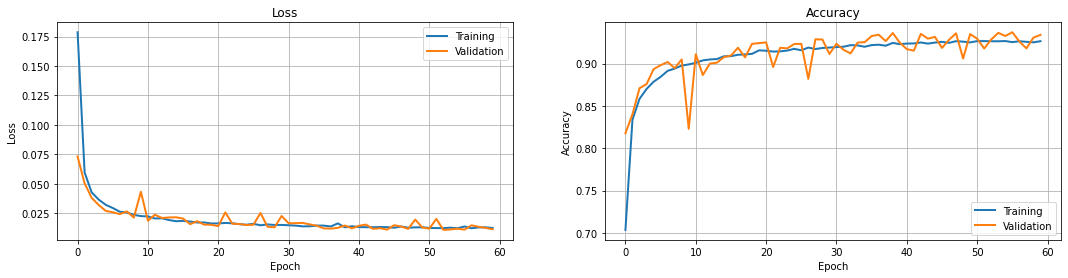

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

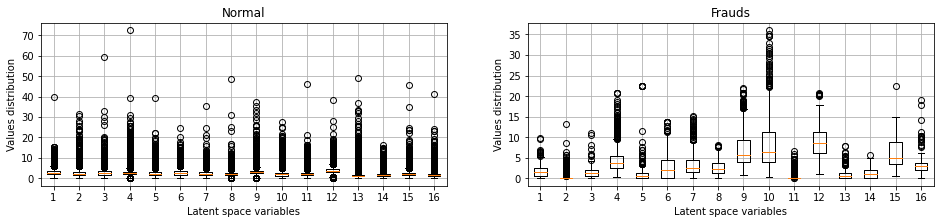

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
### Quinto Cambio: Aumento en el número de neuronas en los encoder/decoder: 128 neuronas

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
#encoder = Dense(64, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(in_layer)
encoder = Dense(128, activation='relu')(in_layer)
latent  = Dense(16,  activation='relu')(encoder)
decoder = Dense(128, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_13 (Dense)             (None, 29)                3741      
Total params: 11,821
Trainable params: 11,821
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = AE.fit(x_train, x_train, epochs=60, batch_size=64, validation_split=0.2)

Epoch 1/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.1995 - accuracy: 0.6804 - val_loss: 0.0862 - val_accuracy: 0.8038
Epoch 2/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0718 - accuracy: 0.8177 - val_loss: 0.0620 - val_accuracy: 0.8319
Epoch 3/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0530 - accuracy: 0.8451 - val_loss: 0.0466 - val_accuracy: 0.8530
Epoch 4/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0409 - accuracy: 0.8603 - val_loss: 0.0334 - val_accuracy: 0.8764
Epoch 5/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0343 - accuracy: 0.8750 - val_loss: 0.0295 - val_accuracy: 0.8911
Epoch 6/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0307 - accuracy: 0.8817 - val_loss: 0.0298 - val_accuracy: 0.8899
Epoch 7/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0284 - accuracy: 0.8887 - val_loss: 0.0276 - val_accuracy:

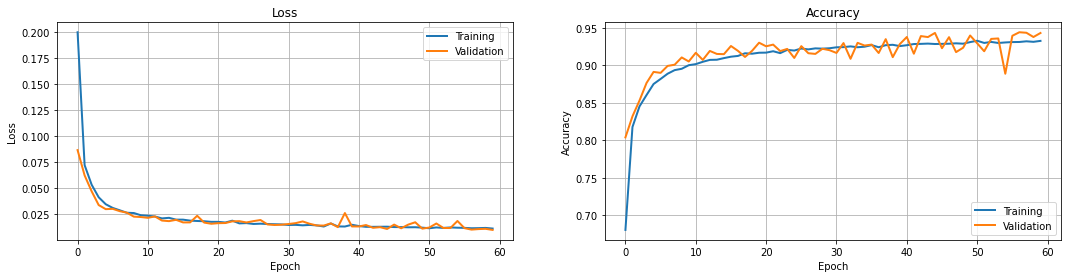

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='#d53a26')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()

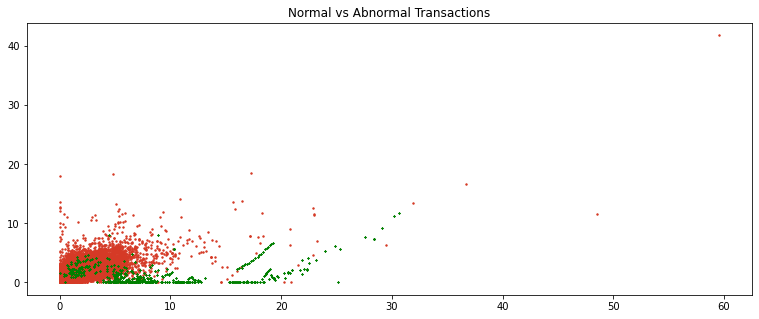

In [0]:
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='#d53a26')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()

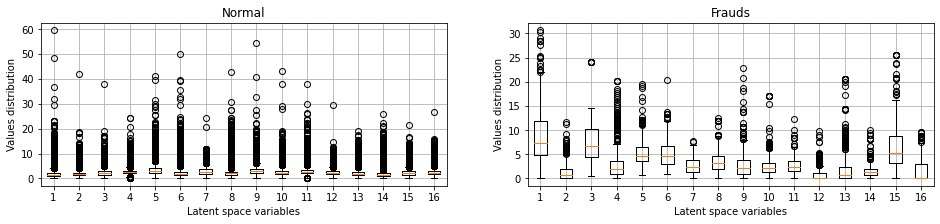

In [0]:
import matplotlib.pyplot as plt


# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()


#### Sexto Cambio: Aumento en el número de neuronas en los encoder/decoder: 256 neuronas

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
#encoder = Dense(64, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(in_layer)
encoder = Dense(256, activation='relu')(in_layer)
latent  = Dense(16,  activation='relu')(encoder)
decoder = Dense(256, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               7680      
_________________________________________________________________
dense_79 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_80 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_81 (Dense)             (None, 29)                7453      
Total params: 23,597
Trainable params: 23,597
Non-trainable params: 0
_________________________________________________________________


In [0]:
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [0]:
history = AE.fit(x_train, x_train, epochs=60, batch_size=64, validation_split=0.2)

Epoch 1/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.1610 - accuracy: 0.7188 - val_loss: 0.0638 - val_accuracy: 0.8184
Epoch 2/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0631 - accuracy: 0.8329 - val_loss: 0.0509 - val_accuracy: 0.8496
Epoch 3/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0500 - accuracy: 0.8550 - val_loss: 0.0365 - val_accuracy: 0.8693
Epoch 4/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0391 - accuracy: 0.8703 - val_loss: 0.0386 - val_accuracy: 0.8790
Epoch 5/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0347 - accuracy: 0.8800 - val_loss: 0.0330 - val_accuracy: 0.8823
Epoch 6/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0332 - accuracy: 0.8837 - val_loss: 0.0309 - val_accuracy: 0.8928
Epoch 7/60
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0286 - accuracy: 0.8930 - val_loss: 0.0300 - val_accuracy:

#### Séptino Cambio: Aumento en el número de neuronas en los encoder/decoder: 500 neuronas

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(500, activation='relu')(in_layer)
latent  = Dense(16,  activation='relu')(encoder)
decoder = Dense(500, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_94 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_95 (Dense)             (None, 16)                8016      
_________________________________________________________________
dense_96 (Dense)             (None, 500)               8500      
_________________________________________________________________
dense_97 (Dense)             (None, 29)                14529     
Total params: 46,045
Trainable params: 46,045
Non-trainable params: 0
_________________________________________________________________


In [0]:
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [0]:
history = AE.fit(x_train, x_train, epochs=60, batch_size=32, validation_split=0.2)

Epoch 1/60
5687/5687 [==============================] - 16s 3ms/step - loss: 0.1289 - accuracy: 0.7659 - val_loss: 0.0713 - val_accuracy: 0.8237
Epoch 2/60
5687/5687 [==============================] - 15s 3ms/step - loss: 0.0566 - accuracy: 0.8452 - val_loss: 0.0509 - val_accuracy: 0.8627
Epoch 3/60
5687/5687 [==============================] - 15s 3ms/step - loss: 0.0451 - accuracy: 0.8609 - val_loss: 0.0380 - val_accuracy: 0.8805
Epoch 4/60
5687/5687 [==============================] - 15s 3ms/step - loss: 0.0385 - accuracy: 0.8723 - val_loss: 0.0401 - val_accuracy: 0.8633
Epoch 5/60
5687/5687 [==============================] - 15s 3ms/step - loss: 0.0305 - accuracy: 0.8853 - val_loss: 0.1109 - val_accuracy: 0.7824
Epoch 6/60
5687/5687 [==============================] - 15s 3ms/step - loss: 0.0335 - accuracy: 0.8871 - val_loss: 0.0248 - val_accuracy: 0.9044
Epoch 7/60
5687/5687 [==============================] - 15s 3ms/step - loss: 0.0298 - accuracy: 0.8954 - val_loss: 0.0216 - val_ac

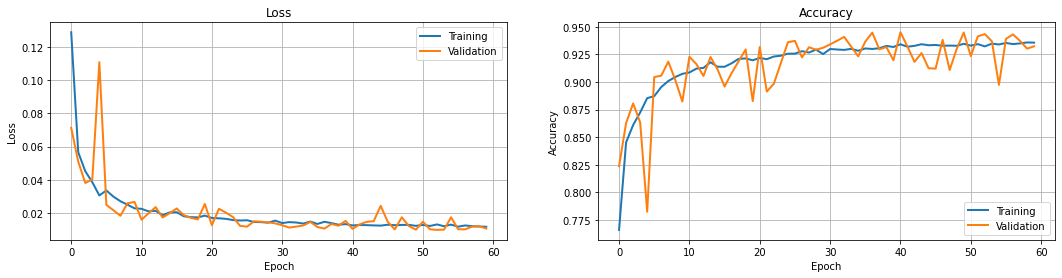

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [0]:
# Predict reconstruction error on training data
x_train_hat = AE.predict(x_train)
mse_train = np.mean(np.power(x_train - x_train_hat, 2), axis=1)

print(f"Min : {mse_train.min():0.6f}")
print(f"Mean: {mse_train.mean():0.4f}")
print(f"Stdd: {mse_train.std():0.2f}")
print(f"Max : {mse_train.max():0.2f}")

Min : 0.000271
Mean: 0.0100
Stdd: 0.06
Max : 15.81


In [0]:
# Predict reconstruction error on test data
x_test_hat = AE.predict(x_test)
mse_test = np.mean(np.power(x_test - x_test_hat, 2), axis=1)
error_test_df = pd.DataFrame({'reconstruction_error': mse_test})
error_test_df.describe()


Min : 0.000219
Mean: 0.0100
Stdd: 0.05
Max : 3.82


In [0]:
# Predict reconstruction error on abnormal data
frauds_hat = AE.predict(frauds)
mse_frauds = np.mean(np.power(frauds - frauds_hat, 2), axis=1)

print(f"Min : {mse_frauds.min():0.6f}")
print(f"Mean: {mse_frauds.mean():0.4f}")
print(f"Stdd: {mse_frauds.std():0.2f}")
print(f"Max : {mse_frauds.max():0.2f}")

Min : 0.000946
Mean: 2.5940
Stdd: 5.72
Max : 54.66


In [0]:
# Predict reconstruction error on normal data
normal_hat = AE.predict(normal)
mse_normal = np.mean(np.power(normal - normal_hat, 2), axis=1)

print(f"Min : {mse_normal.min():0.6f}")
print(f"Mean: {mse_normal.mean():0.4f}")
print(f"Stdd: {mse_normal.std():0.2f}")
print(f"Max : {mse_normal.max():0.2f}")

Min : 0.000219
Mean: 0.0100
Stdd: 0.06
Max : 15.81


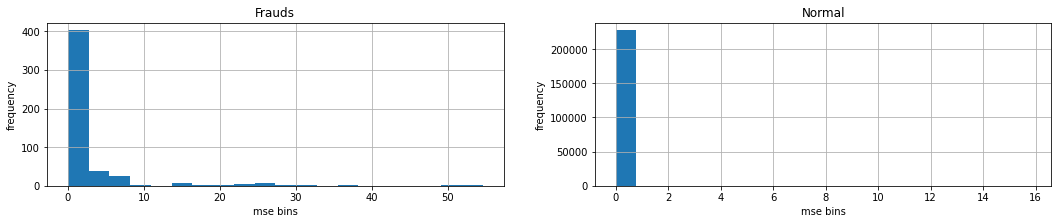

In [0]:
# Plot distribution of reconstruction errors
plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Frauds')
plt.hist(mse_frauds, bins=20)
plt.xlabel('mse bins')
plt.ylabel('frequency')
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Normal')
plt.hist(mse_train, bins=20)
plt.xlabel('mse bins')
plt.ylabel('frequency')
plt.grid()

plt.show()

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
encoder_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_94 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_95 (Dense)             (None, 16)                8016      
Total params: 23,016
Trainable params: 23,016
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

print(latent_normal.shape)
print(latent_frauds.shape)

(56863, 16)
(492, 16)


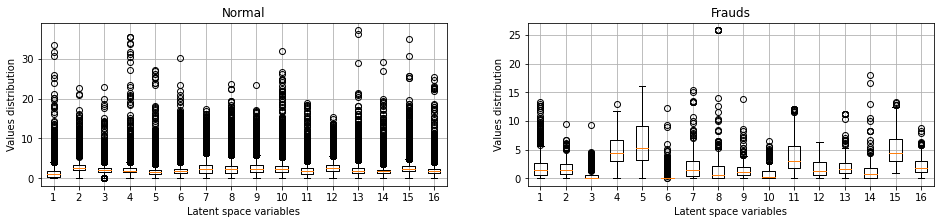

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

#### Octavo Cambio: Solo una capa oculta: latente

In [0]:
# Create model
in_layer = Input(shape=(x_train.shape[1],)) 
latent  = Dense(16,  activation='relu')(in_layer)
out_layer = Dense(x_train.shape[1])(latent)

AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                493       
Total params: 973
Trainable params: 973
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 7s 2ms/step - loss: 0.3849 - accuracy: 0.5059 - val_loss: 0.3994 - val_accuracy: 0.5045
Epoch 2/30
2844/2844 [==============================] - 7s 2ms/step - loss: 0.3843 - accuracy: 0.5085 - val_loss: 0.4000 - val_accuracy: 0.5075
Epoch 3/30
2844/2844 [==============================] - 7s 2ms/step - loss: 0.3840 - accuracy: 0.5128 - val_loss: 0.4004 - val_accuracy: 0.5123
Epoch 4/30
2844/2844 [==============================] - 7s 2ms/step - loss: 0.3833 - accuracy: 0.5161 - val_loss: 0.4017 - val_accuracy: 0.5158
Epoch 5/30
2844/2844 [==============================] - 7s 2ms/step - loss: 0.3830 - accuracy: 0.5192 - val_loss: 0.4040 - val_accuracy: 0.5204
Epoch 6/30
2844/2844 [==============================] - 7s 2ms/step - loss: 0.3829 - accuracy: 0.5231 - val_loss: 0.4019 - val_accuracy: 0.5231
Epoch 7/30
2844/2844 [==============================] - 7s 2ms/step - loss: 0.3828 - accuracy: 0.5268 - val_loss: 0.4009 - val_accuracy:

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                480       
Total params: 480
Trainable params: 480
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

print(latent_normal.shape)
print(latent_frauds.shape)

(56863, 16)
(492, 16)


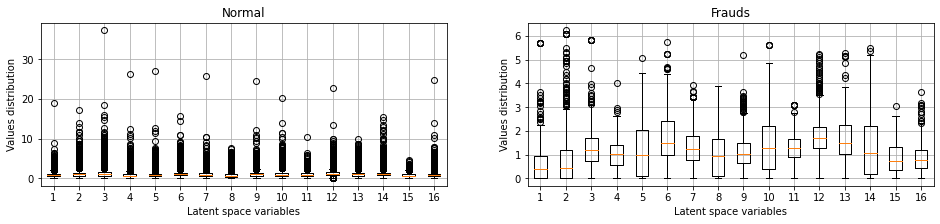

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

#### Noveno Cambio: Al mejor modelo del ejercicio 1 quitarle elementos en la capa latente

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(500, activation='relu')(in_layer)
latent  = Dense(8,  activation='relu')(encoder)
decoder = Dense(500, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               15000     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 2004      
_________________________________________________________________
dense_8 (Dense)              (None, 500)               2500      
_________________________________________________________________
dense_9 (Dense)              (None, 29)                14529     
Total params: 34,033
Trainable params: 34,033
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.5703 - accuracy: 0.2775 - val_loss: 0.4795 - val_accuracy: 0.3583
Epoch 2/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.4439 - accuracy: 0.3797 - val_loss: 0.4315 - val_accuracy: 0.4106
Epoch 3/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3937 - accuracy: 0.4239 - val_loss: 0.4549 - val_accuracy: 0.4119
Epoch 4/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3733 - accuracy: 0.4441 - val_loss: 0.3831 - val_accuracy: 0.4509
Epoch 5/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3595 - accuracy: 0.4564 - val_loss: 0.3669 - val_accuracy: 0.4546
Epoch 6/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3492 - accuracy: 0.4693 - val_loss: 0.3449 - val_accuracy: 0.4805
Epoch 7/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3389 - accuracy: 0.4804 - val_loss: 0.3494 - val_accuracy:

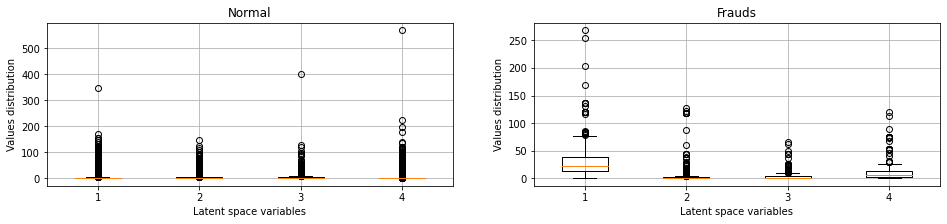

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()


#### Decimo Cambio: Al mejor modelo del ejercicio 1, aumentarle elementos en la capa latente

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(500, activation='relu')(in_layer)
latent  = Dense(29,  activation='relu')(encoder)
decoder = Dense(500, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_11 (Dense)             (None, 29)                14529     
_________________________________________________________________
dense_12 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_13 (Dense)             (None, 29)                14529     
Total params: 59,058
Trainable params: 59,058
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0433 - accuracy: 0.8744 - val_loss: 0.0121 - val_accuracy: 0.9213
Epoch 2/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0172 - accuracy: 0.9142 - val_loss: 0.0355 - val_accuracy: 0.8721
Epoch 3/30
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0151 - accuracy: 0.9161 - val_loss: 0.0060 - val_accuracy: 0.9426
Epoch 4/30
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0155 - accuracy: 0.9222 - val_loss: 0.0103 - val_accuracy: 0.9348
Epoch 5/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0104 - accuracy: 0.9316 - val_loss: 0.0239 - val_accuracy: 0.9132
Epoch 6/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0109 - accuracy: 0.9312 - val_loss: 0.0073 - val_accuracy: 0.9428
Epoch 7/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0100 - accuracy: 0.9347 - val_loss: 0.0067 - val_accuracy:

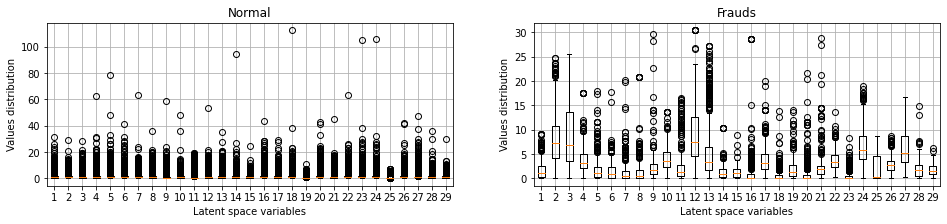

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# == Q ==
# 1. Diseña un AE que obtenga pérdida menor o igual 0.01 tanto en entrenamiento como validación.
#    Reporta tu arquitectura.
# 2. ¿Existe alguna relación entre la profundidad del AE y la pérdida final?
# 3. ¿Existe alguna relación entre la profundidad del AE y la separación resultante
#    entre los espacios latentes de los datos normales y anormales?
# 4. ¿Existe alguna relación entre el número elementos en el espacio latente y la pérdida final?
# 5. ¿Existe alguna relación entre el número elementos en el espacio latente y la separación resultante
#    entre los espacios latentes de los datos normales y anormales?
# 6. Intenta forzar el espacio latente para que sea ralo. Reporta tu mejor modelo y 
#    el desempeño que obtenga, tanto en pérdida como en capacidad de diferenciar datos anormales.

#### Onceavo Cambio: Al mejor modelo del ejercicio 1: Incluir regularizadores

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(500, activation='relu')(in_layer)
latent  = Dense(16,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(500, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_15 (Dense)             (None, 16)                8016      
_________________________________________________________________
dense_16 (Dense)             (None, 500)               8500      
_________________________________________________________________
dense_17 (Dense)             (None, 29)                14529     
Total params: 46,045
Trainable params: 46,045
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1313 - accuracy: 0.7605 - val_loss: 0.0756 - val_accuracy: 0.8282
Epoch 2/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0530 - accuracy: 0.8497 - val_loss: 0.0593 - val_accuracy: 0.8410
Epoch 3/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0456 - accuracy: 0.8657 - val_loss: 0.0346 - val_accuracy: 0.8797
Epoch 4/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0373 - accuracy: 0.8778 - val_loss: 0.0326 - val_accuracy: 0.8867
Epoch 5/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0338 - accuracy: 0.8845 - val_loss: 0.0282 - val_accuracy: 0.8941
Epoch 6/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0300 - accuracy: 0.8916 - val_loss: 0.0270 - val_accuracy: 0.8949
Epoch 7/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0277 - accuracy: 0.8965 - val_loss: 0.0273 - val_accuracy:

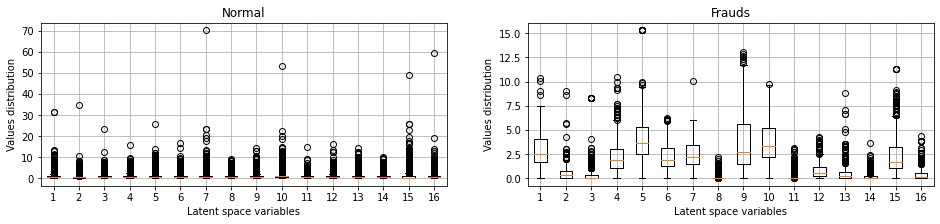

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

# Plot distribution of latent space
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

#### Doceavo Cambio: Al mejor modelo (del ejercicio 1) incluir regularizadores y aumentar elementos en capa latente


In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(500, activation='relu')(in_layer)
latent  = Dense(25,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(500, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_15 (Dense)             (None, 25)                12525     
_________________________________________________________________
dense_16 (Dense)             (None, 500)               13000     
_________________________________________________________________
dense_17 (Dense)             (None, 29)                14529     
Total params: 55,054
Trainable params: 55,054
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0628 - accuracy: 0.8551 - val_loss: 0.0262 - val_accuracy: 0.9055
Epoch 2/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0245 - accuracy: 0.9038 - val_loss: 0.0121 - val_accuracy: 0.9343
Epoch 3/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0245 - accuracy: 0.9087 - val_loss: 0.0113 - val_accuracy: 0.9312
Epoch 4/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0167 - accuracy: 0.9205 - val_loss: 0.0162 - val_accuracy: 0.9179
Epoch 5/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0177 - accuracy: 0.9208 - val_loss: 0.0093 - val_accuracy: 0.9439
Epoch 6/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0151 - accuracy: 0.9266 - val_loss: 0.0158 - val_accuracy: 0.9148
Epoch 7/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0154 - accuracy: 0.9261 - val_loss: 0.0120 - val_accuracy:

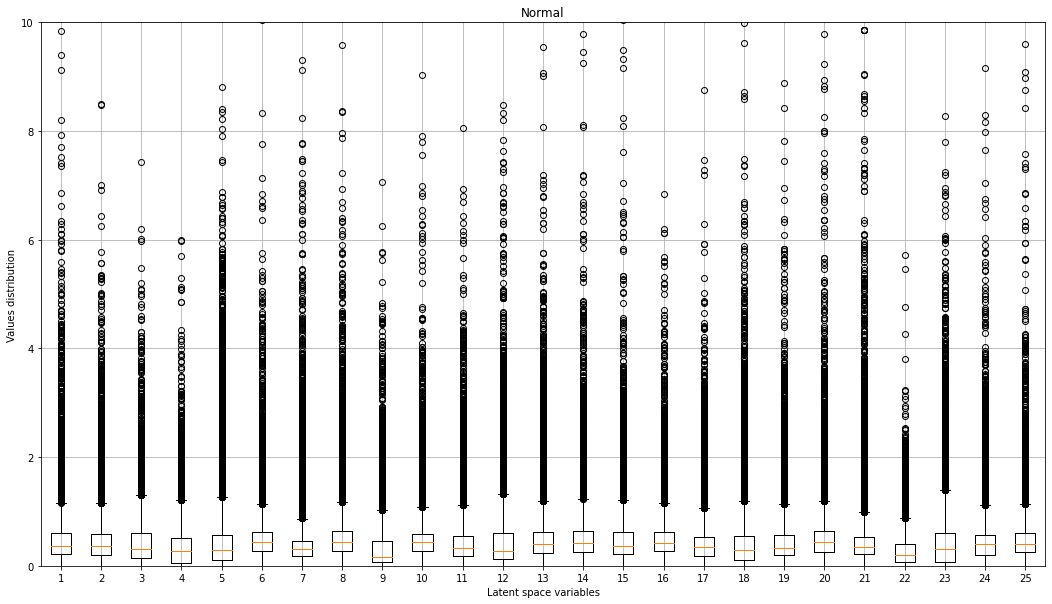

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

# Plot distribution of latent space
plt.figure(figsize=(18, 10))
#plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 


#plt.subplot(1, 2, 2)
#plt.title('Frauds')
#plt.boxplot(latent_frauds)
#plt.xlabel('Latent space variables')
#plt.ylabel('Values distribution')
#plt.grid()
#plt.show()

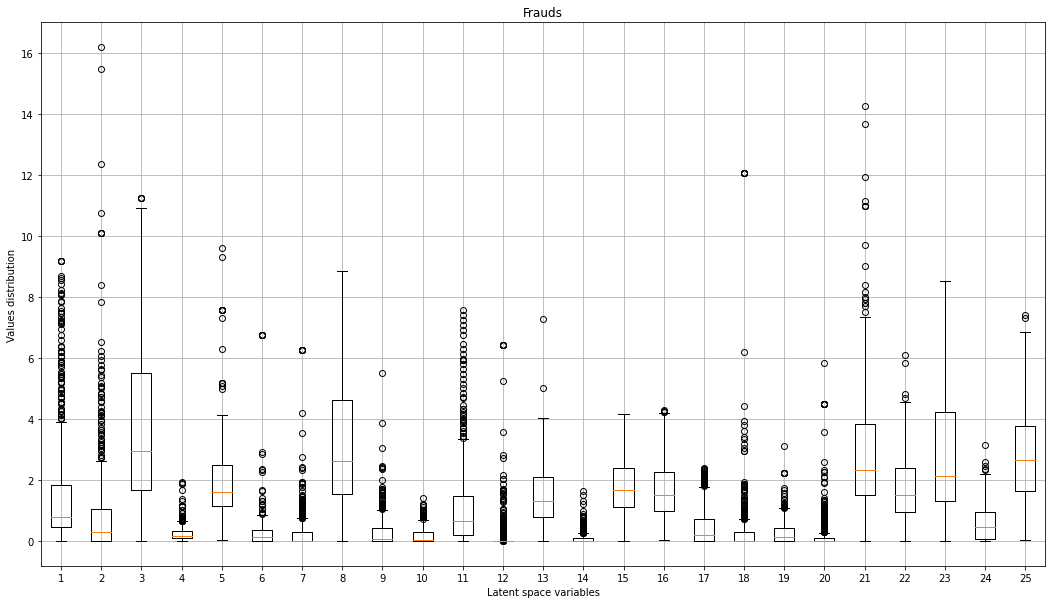

In [0]:
plt.figure(figsize=(18, 10))
#plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

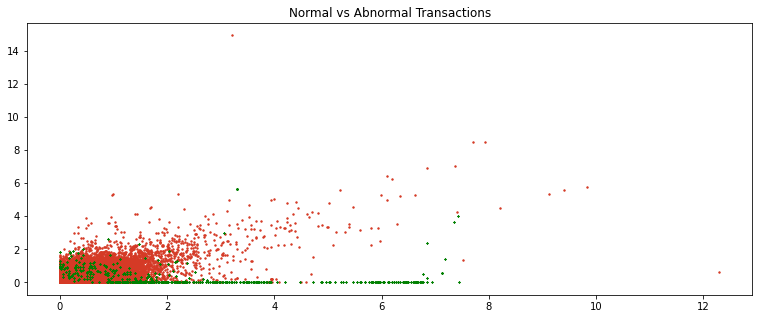

In [0]:
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='#d53a26')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.show()

#### Treceavo Cambio: Al mejor modelo del ejercicio 1, incluir regularizadores y quitar elementos en el espacio latente

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(500, activation='relu')(in_layer)
latent  = Dense(10,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(500, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_19 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_20 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_21 (Dense)             (None, 29)                14529     
Total params: 40,039
Trainable params: 40,039
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.2543 - accuracy: 0.5961 - val_loss: 0.1637 - val_accuracy: 0.6900
Epoch 2/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1418 - accuracy: 0.7186 - val_loss: 0.1274 - val_accuracy: 0.7362
Epoch 3/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1181 - accuracy: 0.7489 - val_loss: 0.1064 - val_accuracy: 0.7601
Epoch 4/30
2844/2844 [==============================] - 7s 3ms/step - loss: 0.1054 - accuracy: 0.7666 - val_loss: 0.0932 - val_accuracy: 0.7841
Epoch 5/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0962 - accuracy: 0.7795 - val_loss: 0.0921 - val_accuracy: 0.7867
Epoch 6/30
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0905 - accuracy: 0.7887 - val_loss: 0.0886 - val_accuracy: 0.7942
Epoch 7/30
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0852 - accuracy: 0.7941 - val_loss: 0.0848 - val_accuracy:

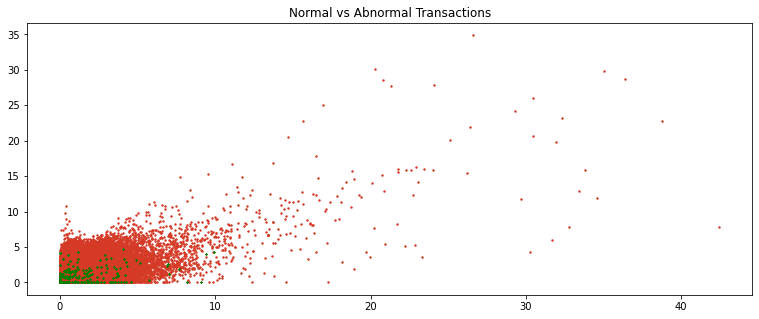

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='#d53a26')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')
plt.show()

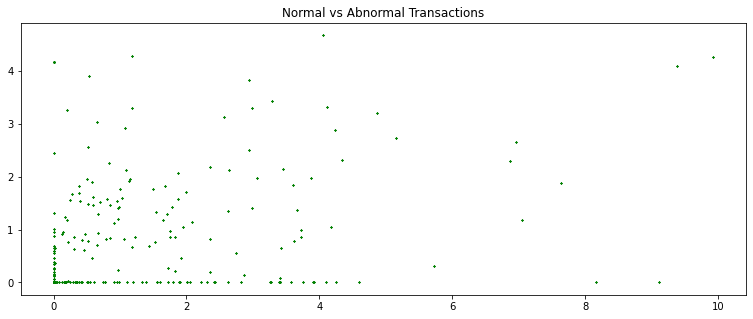

In [0]:
plt.figure(figsize=(13, 5))
#plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='#d53a26')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.show()

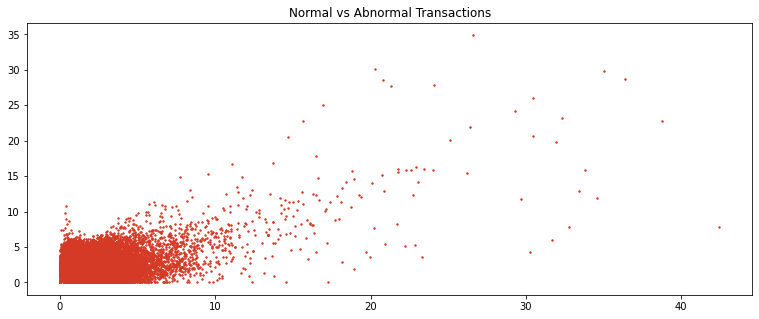

In [0]:
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='#d53a26')
#plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.show()

#### Catorceavo Cambio: Mejor modelo (ejercicio 6) incluir regularizadores

---




In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(128, activation='relu')(in_layer)
#encoder = Dense(24, activation='relu')(encoder)
#encoder = Dense(20, activation='relu')(encoder)
latent  = Dense(12,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
#decoder = Dense(20, activation='relu')(latent)
#decoder = Dense(24, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_84 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_85 (Dense)             (None, 12)                1548      
_________________________________________________________________
dense_86 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_87 (Dense)             (None, 29)                3741      
Total params: 10,793
Trainable params: 10,793
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
2844/2844 [==============================] - 6s 2ms/step - loss: 0.2642 - accuracy: 0.5860 - val_loss: 0.1431 - val_accuracy: 0.6997
Epoch 2/30
2844/2844 [==============================] - 5s 2ms/step - loss: 0.1282 - accuracy: 0.7249 - val_loss: 0.1073 - val_accuracy: 0.7513
Epoch 3/30
2844/2844 [==============================] - 5s 2ms/step - loss: 0.1045 - accuracy: 0.7585 - val_loss: 0.0953 - val_accuracy: 0.7704
Epoch 4/30
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0936 - accuracy: 0.7752 - val_loss: 0.0892 - val_accuracy: 0.7815
Epoch 5/30
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0866 - accuracy: 0.7915 - val_loss: 0.0821 - val_accuracy: 0.7983
Epoch 6/30
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0809 - accuracy: 0.8019 - val_loss: 0.0771 - val_accuracy: 0.8080
Epoch 7/30
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0772 - accuracy: 0.8088 - val_loss: 0.0785 - val_accuracy:

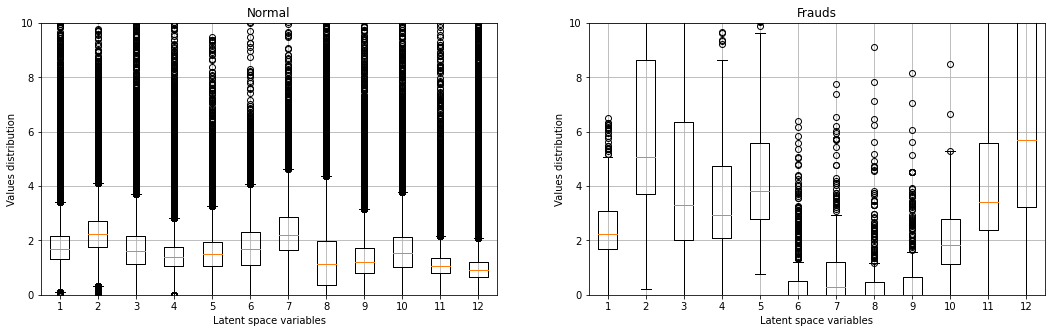

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

# Plot distribution of latent space
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()


plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.ylim([0,10])
plt.grid()
plt.show()

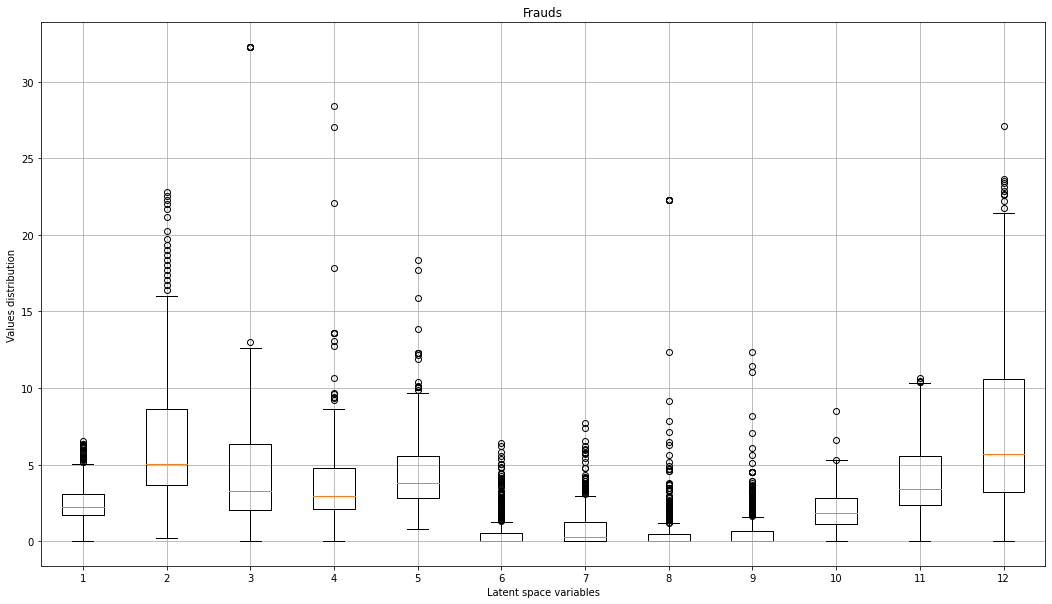

In [0]:
plt.figure(figsize=(18, 10))
#plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

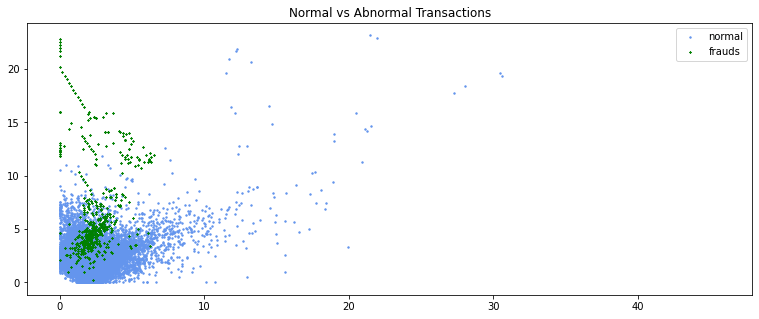

In [0]:
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.legend(['normal', 'frauds'], loc='upper right')

plt.show()

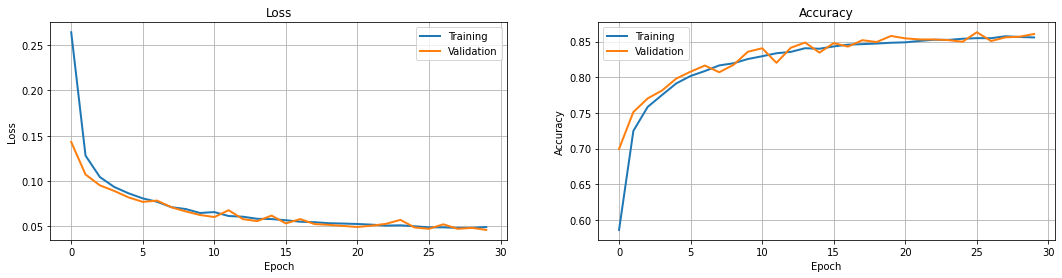

In [0]:
# Plot loss
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

#### Variaciones a los modelos, no importantes


In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(500, activation='relu')(in_layer)
latent  = Dense(14,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(500, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_46 (Dense)             (None, 500)               15000     
_________________________________________________________________
dense_47 (Dense)             (None, 14)                7014      
_________________________________________________________________
dense_48 (Dense)             (None, 500)               7500      
_________________________________________________________________
dense_49 (Dense)             (None, 29)                14529     
Total params: 44,043
Trainable params: 44,043
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=64, validation_split=0.2)

Epoch 1/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1647 - accuracy: 0.7150 - val_loss: 0.2318 - val_accuracy: 0.7099
Epoch 2/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0752 - accuracy: 0.8129 - val_loss: 0.0671 - val_accuracy: 0.8222
Epoch 3/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0620 - accuracy: 0.8334 - val_loss: 0.0475 - val_accuracy: 0.8553
Epoch 4/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0530 - accuracy: 0.8474 - val_loss: 0.0428 - val_accuracy: 0.8709
Epoch 5/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0477 - accuracy: 0.8576 - val_loss: 0.0431 - val_accuracy: 0.8680
Epoch 6/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0417 - accuracy: 0.8661 - val_loss: 0.0484 - val_accuracy: 0.8607
Epoch 7/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0408 - accuracy: 0.8706 - val_loss: 0.0355 - val_accuracy:

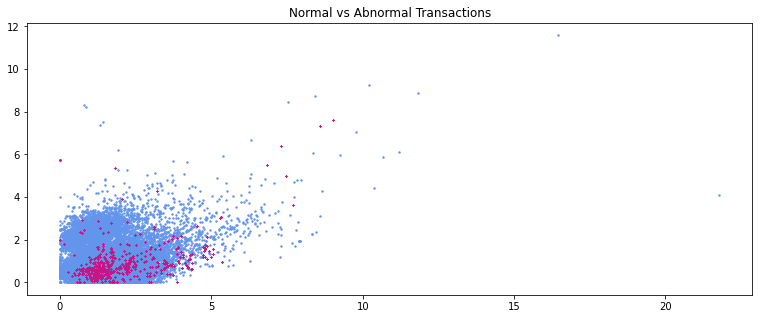

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

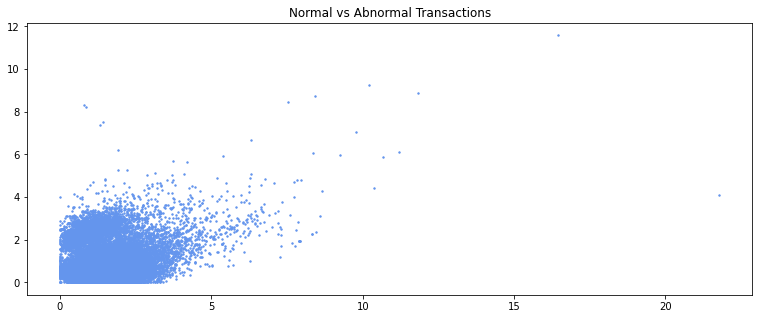

In [0]:
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
#plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.show()

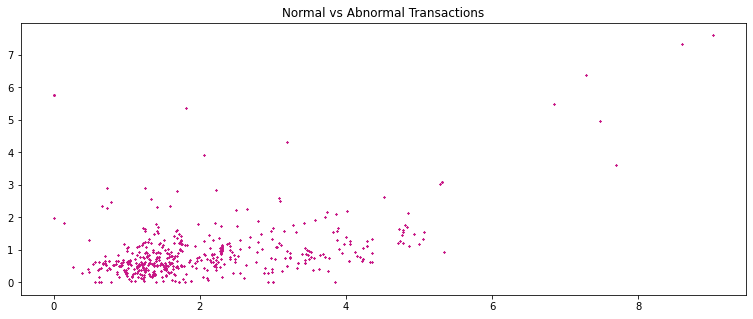

In [0]:
plt.figure(figsize=(13, 5))
#plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

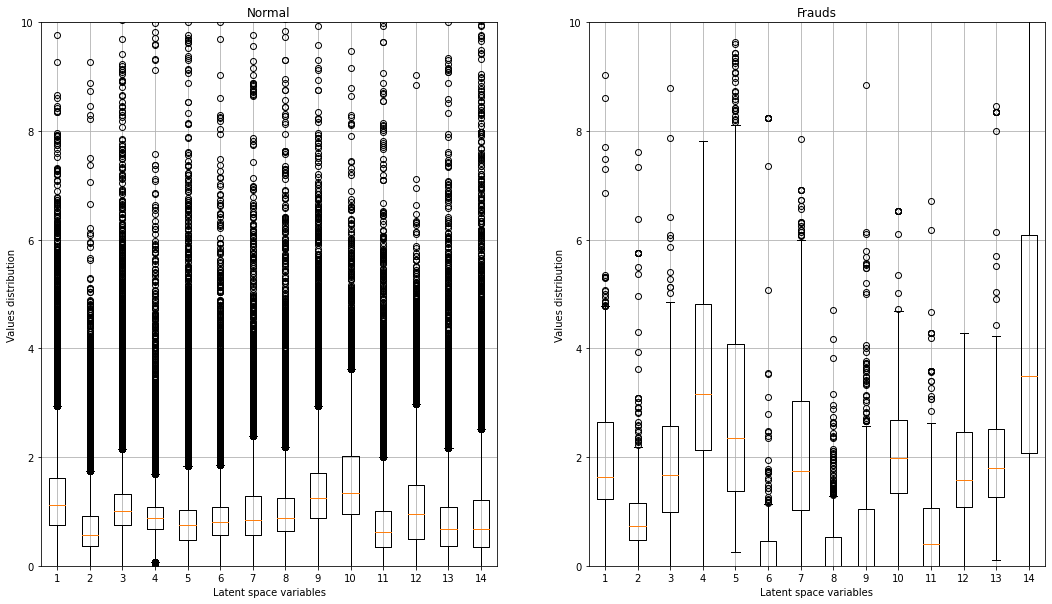

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 

plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylim([0,10])

plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(64, activation='relu')(in_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)

latent  = Dense(8,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = Dense(32, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(64, activation='relu')(decoder)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_105 (Dense)            (None, 64)                1920      
_________________________________________________________________
dense_106 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_107 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_108 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_109 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_110 (Dense)            (None, 32)                105

In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.5766 - accuracy: 0.3206 - val_loss: 0.4396 - val_accuracy: 0.4003
Epoch 2/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3988 - accuracy: 0.4148 - val_loss: 0.3683 - val_accuracy: 0.4398
Epoch 3/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3566 - accuracy: 0.4446 - val_loss: 0.3500 - val_accuracy: 0.4597
Epoch 4/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3336 - accuracy: 0.4755 - val_loss: 0.3348 - val_accuracy: 0.4743
Epoch 5/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3183 - accuracy: 0.5006 - val_loss: 0.3151 - val_accuracy: 0.5152
Epoch 6/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3045 - accuracy: 0.5204 - val_loss: 0.3062 - val_accuracy: 0.5218
Epoch 7/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.2930 - accuracy: 0.5368 - val_loss: 0.2995 - val_accuracy:

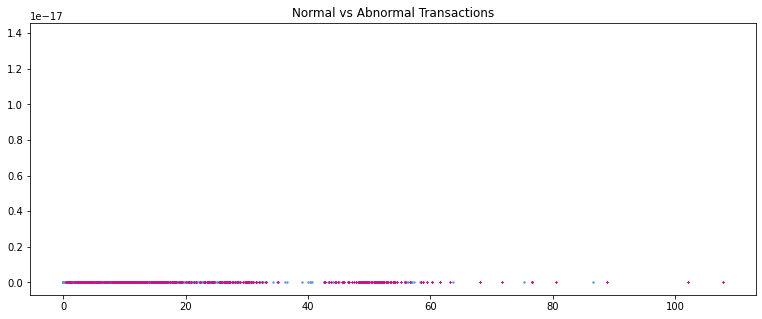

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

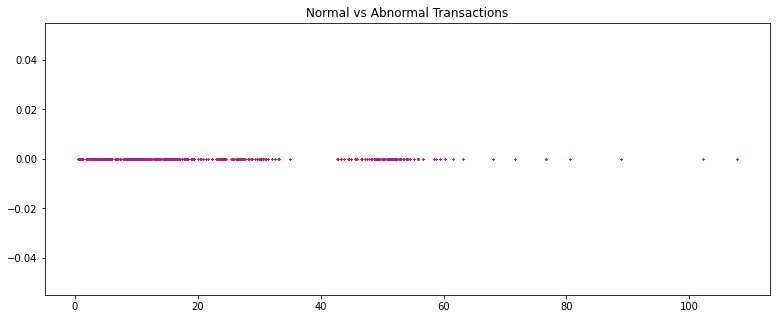

In [0]:
plt.figure(figsize=(13, 5))
#plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

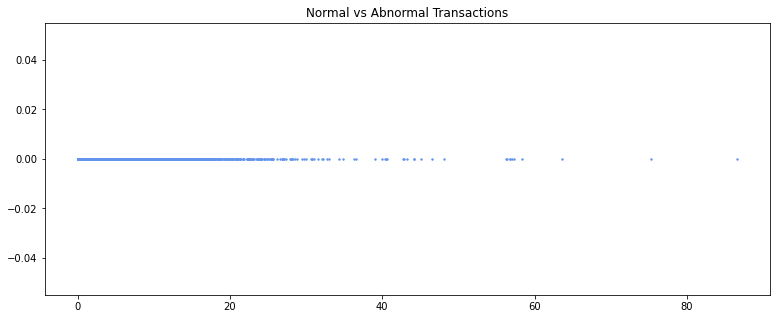

In [0]:
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
#plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='g')
plt.title('Normal vs Abnormal Transactions')
plt.show()

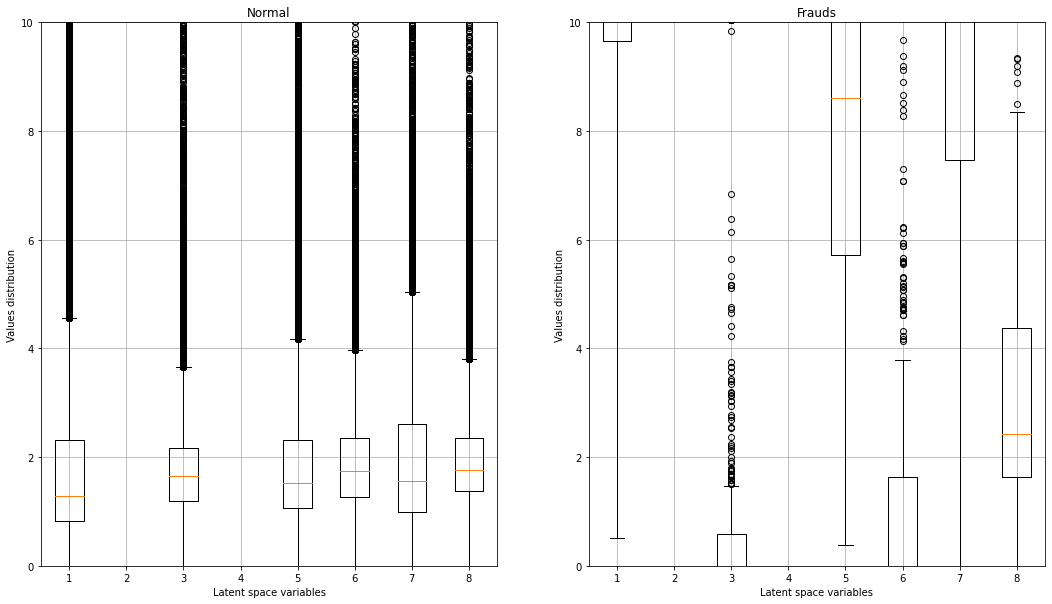

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 

plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylim([0,10])

plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(64, activation='relu')(in_layer)

latent  = Dense(8,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = Dense(64, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_113 (Dense)            (None, 64)                1920      
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 520       
_________________________________________________________________
dense_115 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_116 (Dense)            (None, 29)                1885      
Total params: 4,901
Trainable params: 4,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.5395 - accuracy: 0.3414 - val_loss: 0.4033 - val_accuracy: 0.4252
Epoch 2/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3532 - accuracy: 0.4510 - val_loss: 0.3288 - val_accuracy: 0.4728
Epoch 3/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3115 - accuracy: 0.4789 - val_loss: 0.3068 - val_accuracy: 0.4969
Epoch 4/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.2873 - accuracy: 0.5110 - val_loss: 0.2795 - val_accuracy: 0.5331
Epoch 5/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.2680 - accuracy: 0.5441 - val_loss: 0.2676 - val_accuracy: 0.5578
Epoch 6/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.2535 - accuracy: 0.5652 - val_loss: 0.2496 - val_accuracy: 0.5707
Epoch 7/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.2431 - accuracy: 0.5790 - val_loss: 0.2387 - val_accuracy:

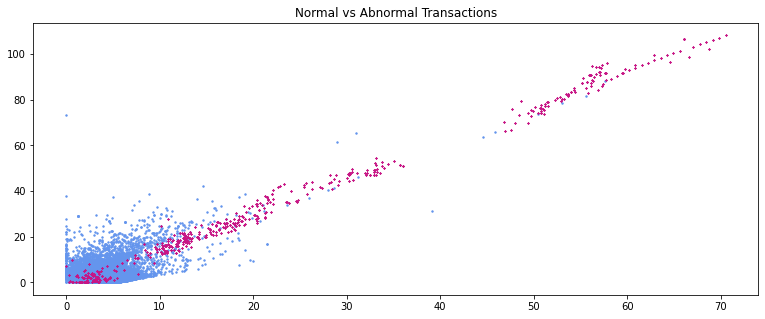

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

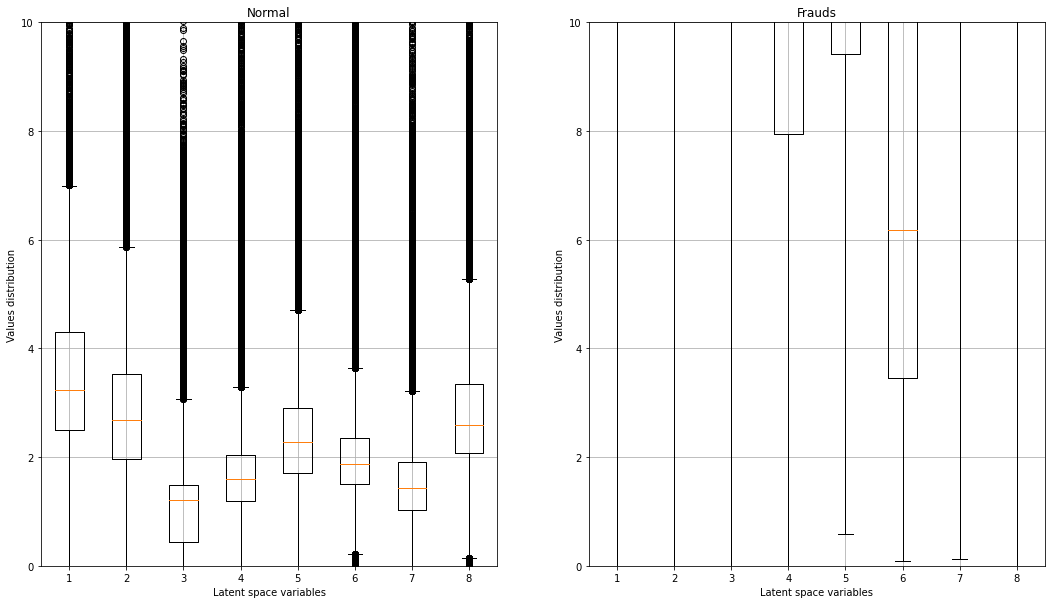

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()


plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylim([0,10])

plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(128, activation='relu')(in_layer)
latent  = Dense(12,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(128, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_55 (Dense)             (None, 12)                1548      
_________________________________________________________________
dense_56 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_57 (Dense)             (None, 29)                3741      
Total params: 10,793
Trainable params: 10,793
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3101 - accuracy: 0.5422 - val_loss: 0.1800 - val_accuracy: 0.6635
Epoch 2/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1406 - accuracy: 0.7207 - val_loss: 0.1235 - val_accuracy: 0.7492
Epoch 3/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1145 - accuracy: 0.7591 - val_loss: 0.1095 - val_accuracy: 0.7659
Epoch 4/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1007 - accuracy: 0.7746 - val_loss: 0.0941 - val_accuracy: 0.7820
Epoch 5/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0908 - accuracy: 0.7819 - val_loss: 0.0890 - val_accuracy: 0.7854
Epoch 6/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0849 - accuracy: 0.7891 - val_loss: 0.0812 - val_accuracy: 0.7947
Epoch 7/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0794 - accuracy: 0.7960 - val_loss: 0.0758 - val_accuracy:

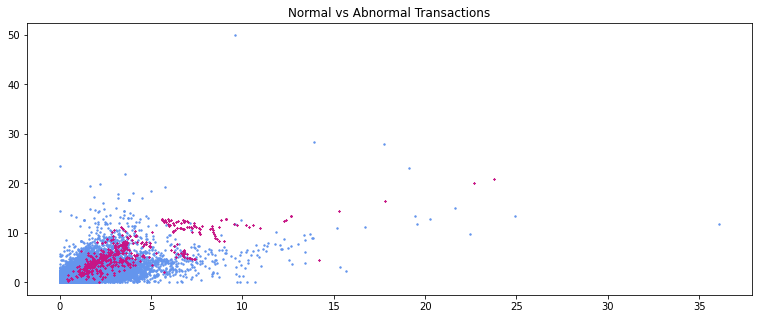

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

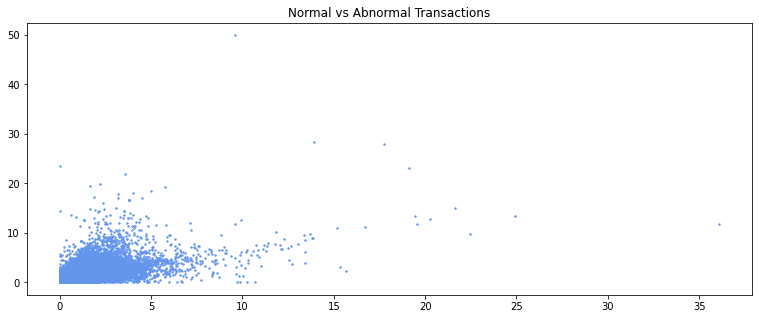

In [0]:
plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
#plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

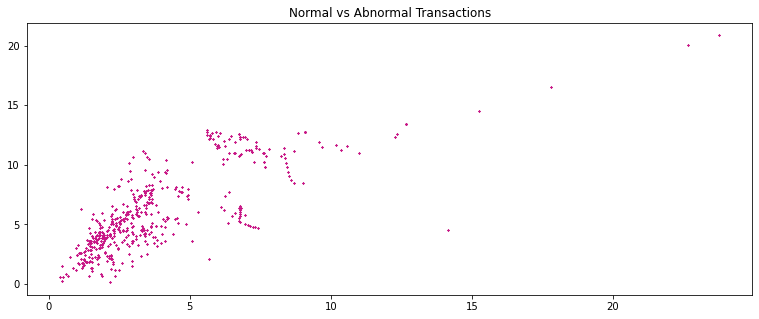

In [0]:
plt.figure(figsize=(13, 5))
#plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

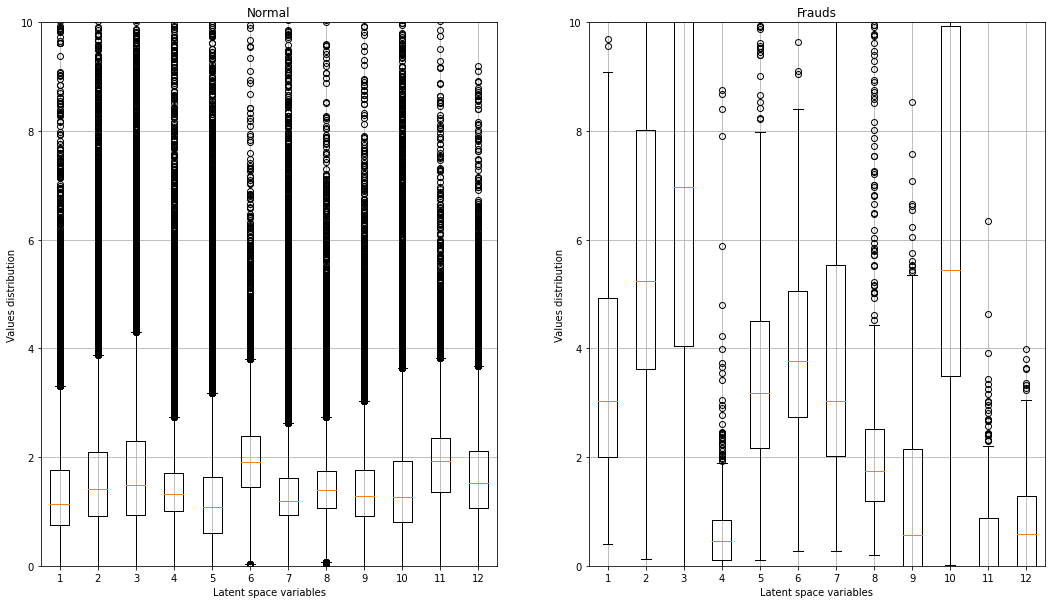

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 

plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylim([0,10])

plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(1000, activation='relu')(in_layer)
latent  = Dense(10,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(1000, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_62 (Dense)             (None, 1000)              30000     
_________________________________________________________________
dense_63 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_64 (Dense)             (None, 1000)              11000     
_________________________________________________________________
dense_65 (Dense)             (None, 29)                29029     
Total params: 80,039
Trainable params: 80,039
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.2659 - accuracy: 0.5784 - val_loss: 0.1592 - val_accuracy: 0.7004
Epoch 2/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1419 - accuracy: 0.7190 - val_loss: 0.1208 - val_accuracy: 0.7413
Epoch 3/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1180 - accuracy: 0.7494 - val_loss: 0.1071 - val_accuracy: 0.7657
Epoch 4/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.1065 - accuracy: 0.7642 - val_loss: 0.1023 - val_accuracy: 0.7762
Epoch 5/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0968 - accuracy: 0.7766 - val_loss: 0.0900 - val_accuracy: 0.7823
Epoch 6/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0884 - accuracy: 0.7871 - val_loss: 0.0826 - val_accuracy: 0.7959
Epoch 7/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0808 - accuracy: 0.7968 - val_loss: 0.0767 - val_accuracy:

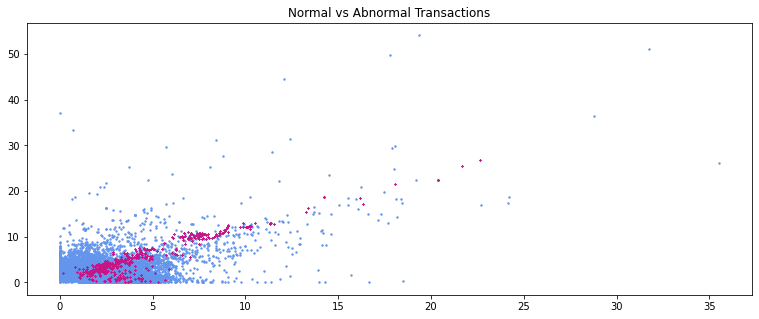

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

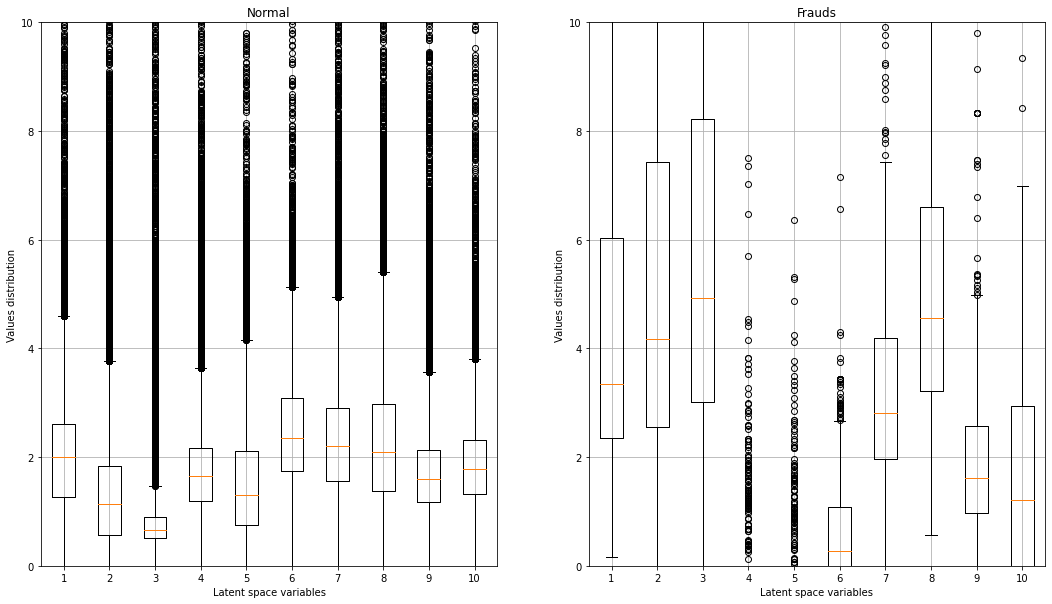

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 

plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylim([0,10])

plt.ylabel('Values distribution')
plt.grid()
plt.show()

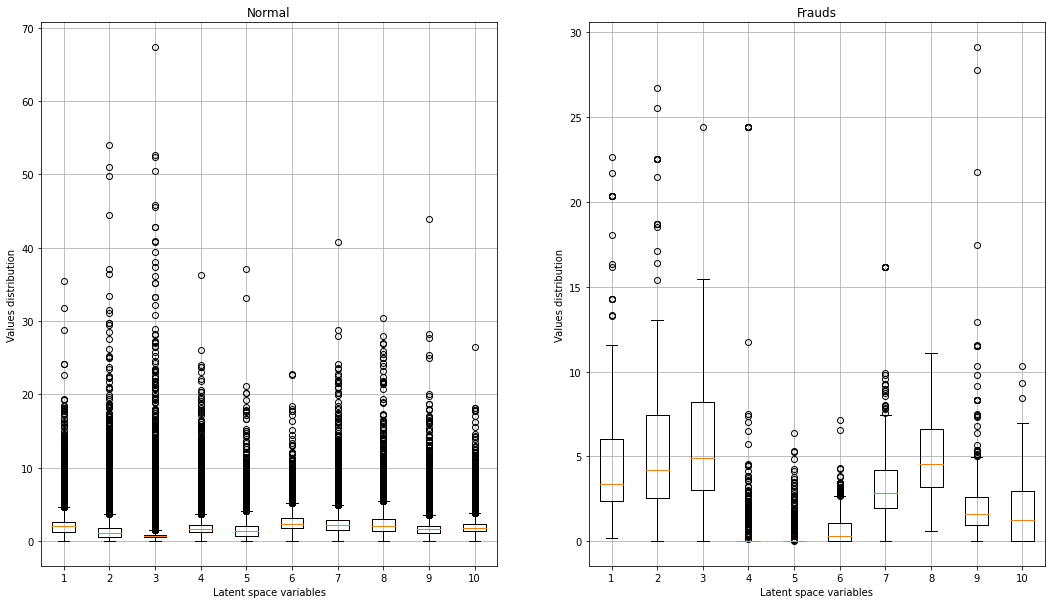

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
#plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 

plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
#plt.ylim([0,10])

plt.ylabel('Values distribution')
plt.grid()

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(64, activation='relu')(in_layer)
latent  = Dense(6,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(64, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                1920      
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_44 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_45 (Dense)             (None, 29)                1885      
Total params: 4,643
Trainable params: 4,643
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=64, validation_split=0.2)

Epoch 1/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.4082 - accuracy: 0.4418 - val_loss: 0.3874 - val_accuracy: 0.4555
Epoch 2/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.3723 - accuracy: 0.4634 - val_loss: 0.3657 - val_accuracy: 0.4735
Epoch 3/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3541 - accuracy: 0.4791 - val_loss: 0.3542 - val_accuracy: 0.4878
Epoch 4/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.3432 - accuracy: 0.4933 - val_loss: 0.3366 - val_accuracy: 0.5046
Epoch 5/60
2844/2844 [==============================] - 7s 3ms/step - loss: 0.3322 - accuracy: 0.5033 - val_loss: 0.3291 - val_accuracy: 0.5085
Epoch 6/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3231 - accuracy: 0.5150 - val_loss: 0.3217 - val_accuracy: 0.5188
Epoch 7/60
2844/2844 [==============================] - 8s 3ms/step - loss: 0.3132 - accuracy: 0.5260 - val_loss: 0.3158 - val_accuracy:

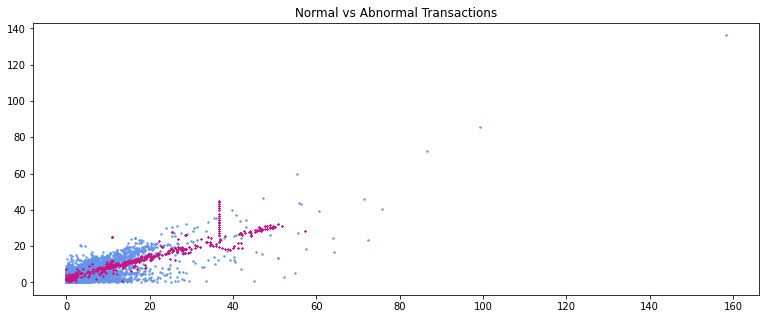

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

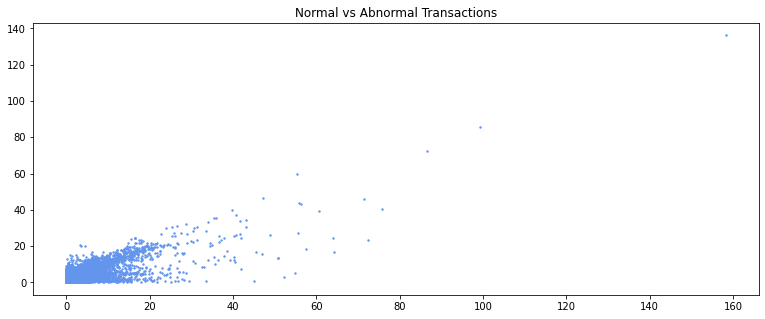

In [0]:

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
#plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

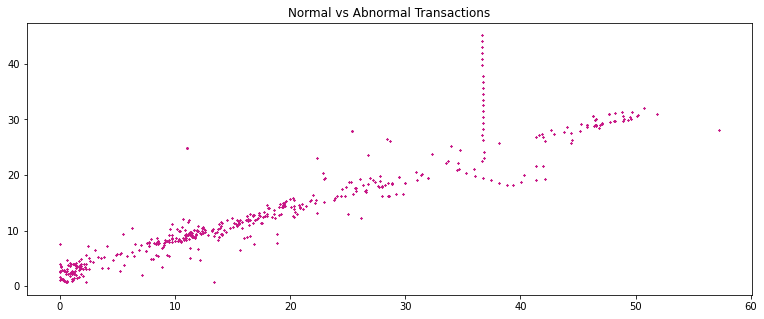

In [0]:

plt.figure(figsize=(13, 5))
#plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.6242 - accuracy: 0.2537 - val_loss: 0.4963 - val_accuracy: 0.3329
Epoch 2/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.4421 - accuracy: 0.3672 - val_loss: 0.4041 - val_accuracy: 0.3978
Epoch 3/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3893 - accuracy: 0.4230 - val_loss: 0.3754 - val_accuracy: 0.4381
Epoch 4/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3640 - accuracy: 0.4481 - val_loss: 0.3599 - val_accuracy: 0.4615
Epoch 5/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3461 - accuracy: 0.4652 - val_loss: 0.3417 - val_accuracy: 0.4700
Epoch 6/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3344 - accuracy: 0.4783 - val_loss: 0.3324 - val_accuracy: 0.4838
Epoch 7/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.3261 - accuracy: 0.4835 - val_loss: 0.3285 - val_accuracy:

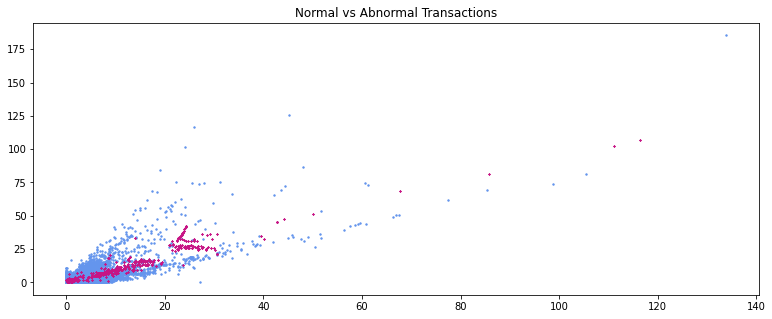

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

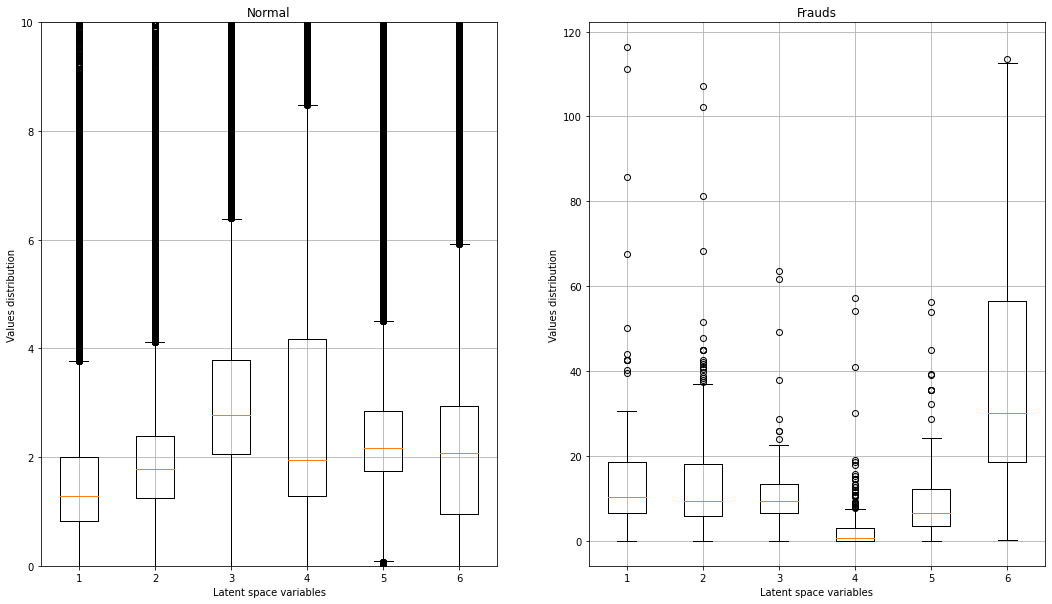

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 

plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
# Create model >0.01
in_layer = Input(shape=(x_train.shape[1],)) 
encoder = Dense(128, activation='relu')(in_layer)
latent  = Dense(29,  activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(128, activation='relu')(latent)
out_layer = Dense(x_train.shape[1])(decoder)
AE = Model(inputs=in_layer, outputs=out_layer)
AE.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_67 (Dense)             (None, 29)                3741      
_________________________________________________________________
dense_68 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_69 (Dense)             (None, 29)                3741      
Total params: 15,162
Trainable params: 15,162
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile
AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train it
history = AE.fit(x_train, x_train, epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0968 - accuracy: 0.8035 - val_loss: 0.0204 - val_accuracy: 0.8977
Epoch 2/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0179 - accuracy: 0.9104 - val_loss: 0.0119 - val_accuracy: 0.9300
Epoch 3/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0138 - accuracy: 0.9269 - val_loss: 0.0084 - val_accuracy: 0.9567
Epoch 4/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0098 - accuracy: 0.9467 - val_loss: 0.0064 - val_accuracy: 0.9677
Epoch 5/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0067 - accuracy: 0.9609 - val_loss: 0.0050 - val_accuracy: 0.9720
Epoch 6/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0070 - accuracy: 0.9609 - val_loss: 0.0051 - val_accuracy: 0.9754
Epoch 7/60
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0055 - accuracy: 0.9678 - val_loss: 0.0130 - val_accuracy:

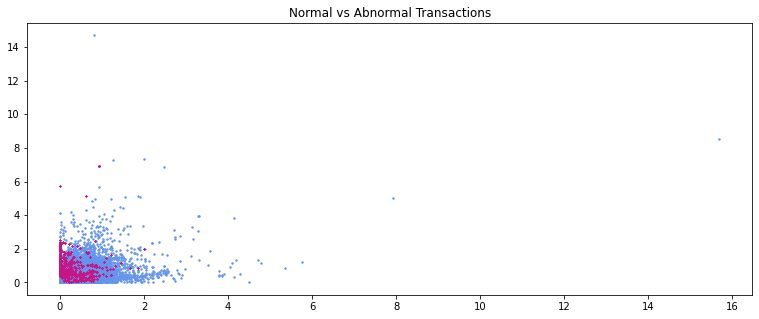

In [0]:
# Create a submodel using only the encoder part of previous model (output must be latent layer)
encoder_model = Model(inputs=in_layer, outputs=latent)

# Predict a latent representation for the test set and the frauds set
latent_normal = encoder_model.predict(x_test)
latent_frauds = encoder_model.predict(frauds)

plt.figure(figsize=(13, 5))
plt.scatter(latent_normal[:,0], latent_normal[:,1], marker='o', s=2, c='cornflowerblue')
plt.scatter(latent_frauds[:,0], latent_frauds[:,1], marker='x', s=2, c='mediumvioletred')
plt.title('Normal vs Abnormal Transactions')
plt.show()

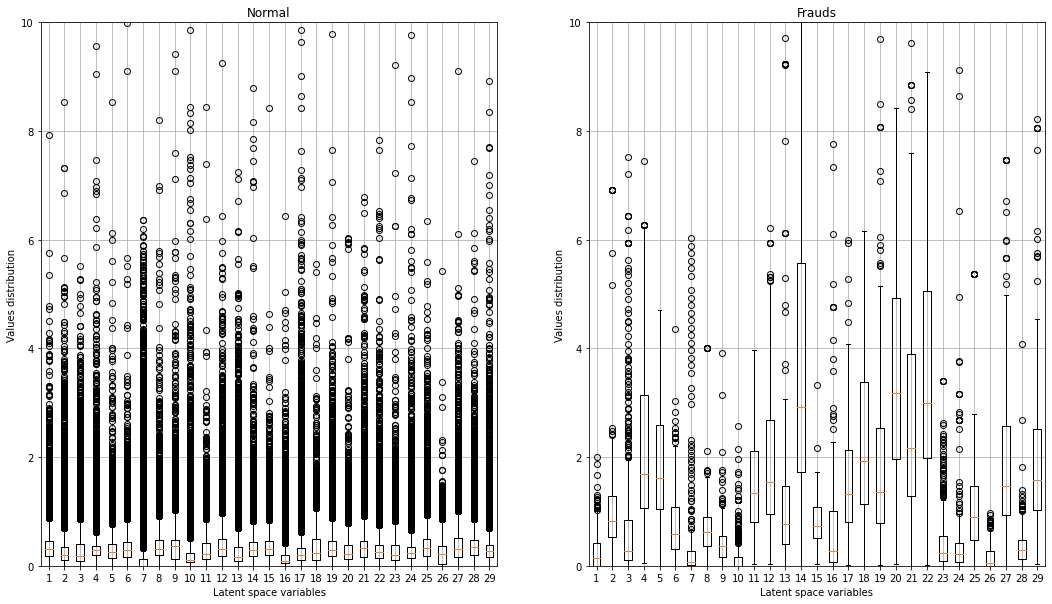

In [0]:
# Plot distribution of latent space
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title('Normal')
plt.boxplot(latent_normal)
plt.ylim([0,10])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()

 

plt.subplot(1, 2, 2)
plt.title('Frauds')
plt.boxplot(latent_frauds)
plt.ylim([0,10])

plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()